In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv(
    "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [2]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    
    processed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])
    return processed_features

In [3]:
def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = california_housing_dataframe["median_house_value"]/1000
    return output_targets

In [4]:
california_housing_dataframe.count()

longitude             17000
latitude              17000
housing_median_age    17000
total_rooms           17000
total_bedrooms        17000
population            17000
households            17000
median_income         17000
median_house_value    17000
dtype: int64

In [5]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2638.3,538.0,1424.7,499.9,3.9,2.0
std,2.1,2.0,12.6,2168.8,417.3,1120.1,380.7,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1467.0,297.0,790.8,282.0,2.6,1.5
50%,34.3,-118.5,29.0,2129.0,434.0,1166.0,410.0,3.6,1.9
75%,37.7,-118.0,37.0,3142.0,648.0,1718.0,605.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,52.0


In [6]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.9
std,116.5
min,15.0
25%,119.8
50%,180.9
75%,266.6
max,500.0


In [7]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2656.6,542.8,1441.4,504.3,3.9,2.0
std,2.1,2.0,12.6,2206.7,431.5,1211.8,393.5,1.9,1.2
min,32.5,-124.2,1.0,18.0,3.0,8.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1446.0,296.0,788.0,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2122.5,434.0,1171.0,406.0,3.5,1.9
75%,37.7,-118.0,37.0,3163.2,651.0,1726.2,607.0,4.7,2.3
max,42.0,-114.6,52.0,26322.0,4952.0,35682.0,4769.0,15.0,55.2


In [8]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,205.9
std,114.7
min,15.0
25%,118.8
50%,179.1
75%,259.5
max,500.0


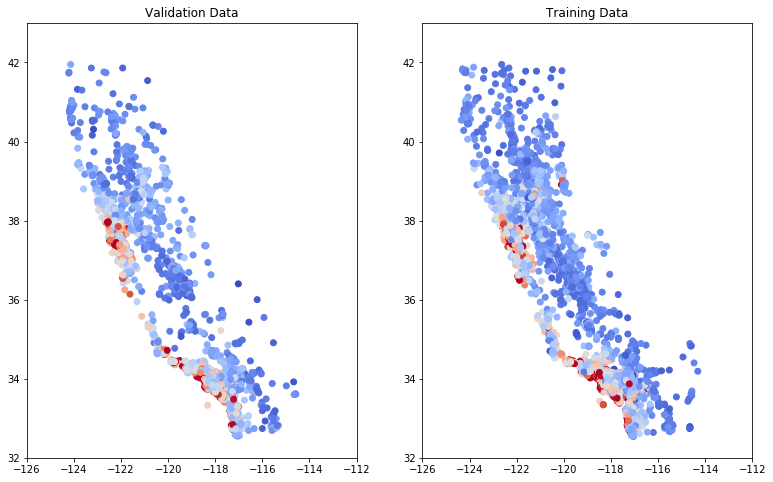

In [9]:
plt.figure(figsize=(13,8))
ax = plt.subplot(1,2,1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])
plt.scatter(
    validation_examples["longitude"],
    validation_examples["latitude"],
    cmap="coolwarm",
    c=validation_targets["median_house_value"]/validation_targets["median_house_value"].max()
)

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])

plt.scatter(
    training_examples["longitude"],
    training_examples["latitude"],
    cmap="coolwarm",
    c=training_targets["median_house_value"]/training_targets["median_house_value"].max()
)
_= plt.plot()

In [10]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [11]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [20]:
def train_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples,
      training_targets["median_house_value"],
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples,
      training_targets["median_house_value"],
      num_epochs=1,
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples,
      validation_targets["median_house_value"],
      num_epochs=1,
      shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 224.72
  period 01 : 212.17
  period 02 : 200.66
  period 03 : 190.47
  period 04 : 185.10
  period 05 : 180.52
  period 06 : 174.03
  period 07 : 169.60
  period 08 : 167.59
  period 09 : 167.57
Model training finished.


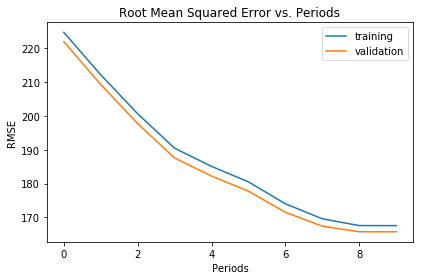

In [23]:
linear_regressor = train_model(
    learning_rate=.0001,
    steps = 100,
    batch_size = 5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets
)

In [25]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=',')

In [26]:
test_examples = preprocess_features(california_housing_test_data)
test_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0
mean,35.6,-119.6,28.8,2599.6,530.0,1402.8,489.9,3.8,2.0
std,2.1,2.0,12.6,2155.6,415.7,1030.5,365.4,1.9,1.1
min,32.6,-124.2,1.0,6.0,2.0,5.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1401.0,291.0,780.0,273.0,2.5,1.5
50%,34.3,-118.5,29.0,2106.0,437.0,1155.0,409.5,3.5,1.9
75%,37.7,-118.0,37.0,3129.0,636.0,1742.8,597.2,4.7,2.3
max,41.9,-114.5,52.0,30450.0,5419.0,11935.0,4930.0,15.0,33.8


In [27]:
test_targets = preprocess_targets(california_housing_test_data)
test_targets.describe()

,median_house_value
count,3000.0
mean,205.8
std,113.1
min,22.5
25%,121.2
50%,177.6
75%,264.0
max,500.0


In [28]:
predict_test_input_fn = lambda: my_input_fn(
      test_examples,
      test_targets["median_house_value"],
      num_epochs=1,
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

test_RMS = math.sqrt(metrics.mean_squared_error(test_predictions,test_targets))

print("RMS on test data: %0.2f" % test_RMS)


RMS on test data: 161.73
